## Imports

In [1]:
import pandas as pd
import numpy as np
from keras.optimizers import Adam

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

warnings.filterwarnings("ignore")  # Ignore warnings for convergence issues


## Functions

Preprocessing functions

In [2]:
def convert_time_and_set_index(df, time_column='time'):
    df[time_column] = pd.to_datetime(df[time_column], unit='s')
    df.set_index(time_column, inplace=True)
    return df
def add_features(df):
    df['price_change'] = df['close'].diff()
    # df['price_change_pct'] = df['close'].pct_change() * 100
    df['price_spread'] = df['high'] - df['low']
    df['price_volatility'] = df[['open', 'high', 'low', 'close']].std(axis=1)
    # df['price_momentum'] = df['close'] - df['close'].shift(1)
    df['price_trend'] = (df['close'] > df['open']).astype(int)
    # df['high_low_ratio'] = df['high'] / df['low']
    # df['close_open_ratio'] = df['close'] / df['open']

    # Moving Averages
    df['close_sma_5'] = df['close'].rolling(window=5).mean()
    df['close_sma_10'] = df['close'].rolling(window=10).mean()
    df['close_ema_10'] = df['close'].ewm(span=10, min_periods=0, adjust=False).mean()
    return df

def normalize_data(data):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    return scaler, scaled_data

def split_data(scaled_data):
    X = scaled_data[:, :-1] 
    y = scaled_data[:, -1]  
    return X, y
def generate_classification_labels(predicted_prices):
    labels = []
    for i in range(len(predicted_prices) - 1):
        if predicted_prices[i + 1] > predicted_prices[i]:
            labels.append(1)  # Buy
        else:
            labels.append(0)  # Don't Buy
    return labels


Models

In [3]:
def train_and_evaluate_linear_regression(X_train, y_train, X_test, y_test):
    linear_regression = LinearRegression()
    linear_regression.fit(X_train, y_train)
    y_pred = linear_regression.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    return {"Mean Squared Error": mse, "R-squared": r2, "Mean Absolute Error": mae, "Model": linear_regression}


def train_and_evaluate_ridge_regression(X_train, y_train, X_test, y_test):
    ridge_regression = Ridge(alpha=0.1)
    ridge_regression.fit(X_train, y_train)
    y_pred = ridge_regression.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    return {"Mean Squared Error": mse, "R-squared": r2, "Mean Absolute Error": mae, "Model": ridge_regression}


def train_and_evaluate_random_forest_regressor(X_train, y_train, X_test, y_test):
    random_forest_regressor = RandomForestRegressor(max_depth=20,min_samples_leaf=2,min_samples_split=2,n_estimators=300)
    random_forest_regressor.fit(X_train, y_train)
    y_pred = random_forest_regressor.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    return {"Mean Squared Error": mse, "R-squared": r2, "Mean Absolute Error": mae, "Model": random_forest_regressor}


def train_and_evaluate_lstm_regression_model(X_train, y_train, X_test, y_test):
    lstm_regression_model = Sequential([
        LSTM(64, activation='relu', input_shape=(X_train.shape[1], 1), return_sequences=True),
        LSTM(64, activation='relu'),
        Dense(1)
    ])
    optimizer = Adam(learning_rate=0.0001)  # Adjust learning rate as needed
    lstm_regression_model.compile(optimizer=optimizer, loss='mean_squared_error')
    lstm_regression_model.fit(X_train.reshape(X_train.shape[0], X_train.shape[1], 1), y_train, epochs=25, batch_size=32, validation_split=0.2)
    y_pred = lstm_regression_model.predict(X_test.reshape(X_test.shape[0], X_test.shape[1], 1))
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    return {"Mean Squared Error": mse, "R-squared": r2, "Mean Absolute Error": mae, "Model": lstm_regression_model}


Strategies

In [4]:
def calculate_profit(prices, buy_signals, sell_signals, initial_balance=6000):
    balance = initial_balance
    shares = 0
    last_price = None

    for i in range(len(prices)):
        if i in buy_signals.index:  # Buy signal
            if balance > 0:
                shares_to_buy = balance / prices[i]
                shares += shares_to_buy
                balance -= shares_to_buy * prices[i]
        elif i in sell_signals.index:  # Sell signal
            if shares > 0:
                balance += shares * prices[i]
                shares = 0
        last_price = prices[i]

    # If holding shares at the end, sell them at the last price
    if shares > 0:
        balance += shares * last_price

    return balance - initial_balance


    return balance - initial_balance

def bollinger_bands_strategy(prices):
    prices_series = pd.Series(prices)
    
    # Calculate the middle band (simple moving average)
    middle_band = prices_series.rolling(window=20).mean()
    
    # Calculate upper and lower bands (middle band +/- 2 standard deviations)
    upper_band = middle_band + 2 * prices_series.rolling(window=20).std()
    lower_band = middle_band - 2 * prices_series.rolling(window=20).std()
    
    # Generate signals
    buy_signals = prices_series[prices_series < lower_band]
    sell_signals = prices_series[prices_series > upper_band]
    
    return calculate_profit(prices, buy_signals, sell_signals)
def rsi_strategy(prices):
    # Convert numpy array to pandas Series
    prices = pd.Series(prices)
    
    # Calculate Relative Strength Index (RSI)
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    
    # Generate signals
    buy_signals = prices[(rsi < 30) & (rsi.shift(1) > 30)]
    sell_signals = prices[(rsi > 70) & (rsi.shift(1) < 70)]
    
    return calculate_profit(prices, buy_signals, sell_signals)



In [5]:
def generate_labels(data):
    labels = []
    for i in range(len(data) - 1):
        if data[i + 1] > data[i]:
            labels.append(1)  # Buy
        else:
            labels.append(0)  # Sell
    return labels
def generate_signals(df, short_ma='Short_MA', long_ma='Long_MA'):
    df['Signal'] = 0
    df['Signal'] = np.where(df[short_ma] > df[long_ma], 1, 0)
    df['Position'] = df['Signal'].diff()
    return df
def train_classification_model(X_train, y_train):
    classification_model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        LSTM(50),
        Dropout(0.2),
        Dense(25),
        Dense(1, activation='sigmoid')
    ])
    classification_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    classification_model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2)
    return classification_model

## Data Loading

In [6]:
stock1 = pd.read_csv('data/EGX_DLY_COMI, 1D.csv')
stock2 = pd.read_csv('data/EGX_DLY_EGX30, 1D.csv')
stock3 = pd.read_csv('data/EGX_DLY_EMFD, 1D.csv')
stock4 = pd.read_csv('data/EGX_DLY_ISPH, 1D.csv')



## Data Visualization

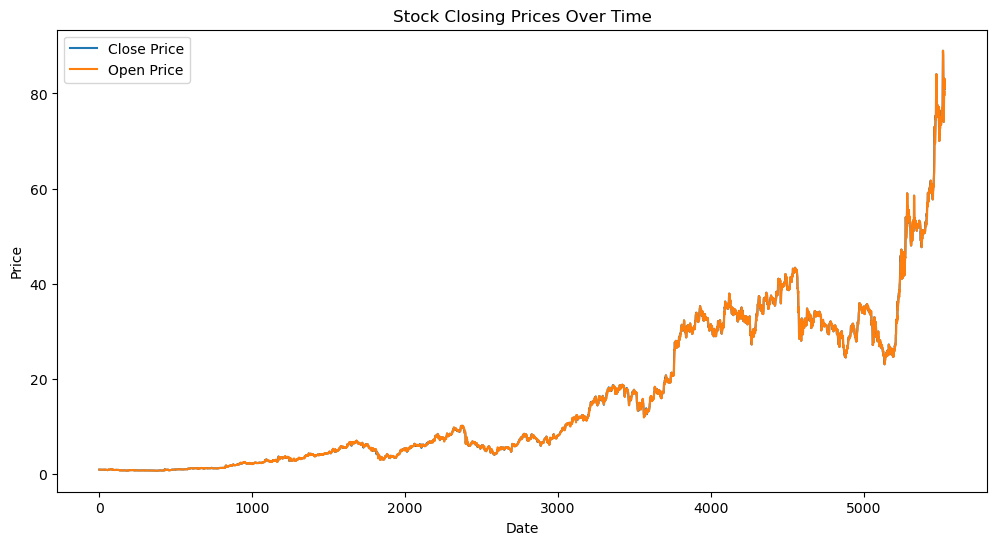

In [7]:

plt.figure(figsize=(12, 6))
plt.plot(stock1['close'], label='Close Price')
plt.plot(stock1['open'], label='Open Price')

plt.title('Stock Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


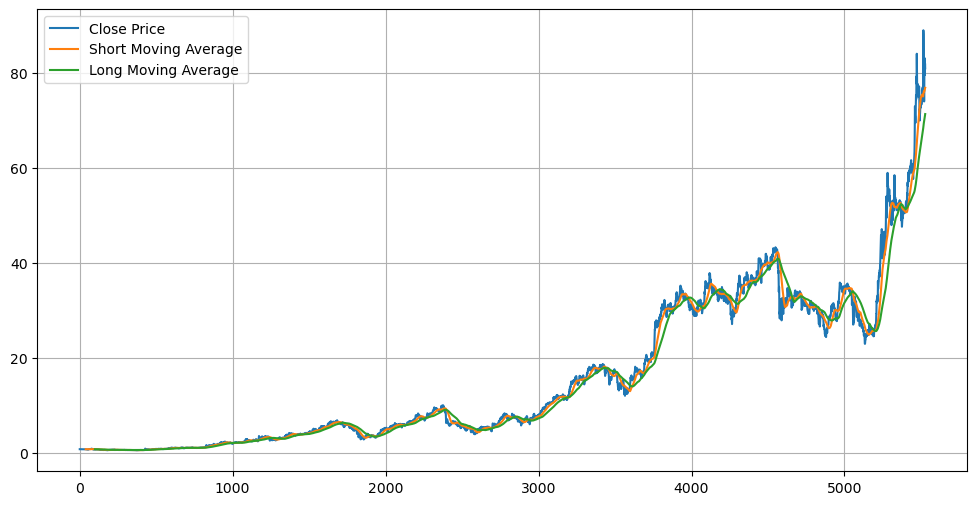

In [8]:
stock1['Short_MA'] = stock1['close'].rolling(window=40).mean()
stock1['Long_MA'] = stock1['close'].rolling(window=100).mean()


plt.figure(figsize=(12,6))
plt.grid(True)
plt.plot(stock1['close'],label='Close Price')
plt.plot(stock1['Short_MA'], label='Short Moving Average')
plt.plot(stock1['Long_MA'], label='Long Moving Average')
plt.legend(loc=2)
plt.show()

## Model

Choose the best Model for price prediction

In [9]:
data = stock1

data=convert_time_and_set_index(data)
print(data.head())
data=add_features(data)
data.dropna(inplace=True)
scaler, scaled_data = normalize_data(data.values)

X, y = split_data(scaled_data)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

linear_regression_res = train_and_evaluate_linear_regression(X_train, y_train, X_test, y_test)
ridge_regression_res = train_and_evaluate_ridge_regression(X_train, y_train, X_test, y_test)
random_forest_regressor_res = train_and_evaluate_random_forest_regressor(X_train, y_train, X_test, y_test)
lstm_regression_model_res = train_and_evaluate_lstm_regression_model(X_train, y_train, X_test, y_test)

print("Results for Linear Regression:")
print(linear_regression_res)
print("Results for Ridge Regression:")
print(ridge_regression_res)
print("Results for RandomForestRegressor:")
print(random_forest_regressor_res)
print("Results for LSTM Regression:")
print(lstm_regression_model_res)


                         open      high       low     close  Short_MA  Long_MA
time                                                                          
2001-05-15 07:00:00  0.839019  0.839019  0.827202  0.831220       NaN      NaN
2001-05-16 07:00:00  0.827202  0.836419  0.823184  0.826020       NaN      NaN
2001-05-17 07:00:00  0.827202  0.827202  0.820111  0.824366       NaN      NaN
2001-05-20 07:00:00  0.815621  0.821293  0.815385  0.816566       NaN      NaN
2001-05-21 07:00:00  0.813257  0.850836  0.809476  0.831456       NaN      NaN
Epoch 1/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0614 - val_loss: 0.0301
Epoch 2/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0197 - val_loss: 0.0030
Epoch 3/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0024 - val_loss: 0.0013
Epoch 4/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 5/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0010 - val_loss: 8.6217e-04
Epoch 6/25
95/95 ━

Choose the best Model for Classification 

In [10]:
hjfdskjnasxhbfedon



lstm_predictions_scaled = lstm_regression_model_res["Model"].predict(X_test.reshape(X_test.shape[0], X_test.shape[1], 1))
predicted_prices = scaler.inverse_transform(np.concatenate((X_test, lstm_predictions_scaled), axis=1))[:, -1]


classification_labels = generate_classification_labels(predicted_prices)

X_test_with_predictions = np.concatenate((X_test, lstm_predictions_scaled), axis=1)[:-1]

X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_test_with_predictions, classification_labels, test_size=0.2, random_state=42)

classification_results = {}

classifiers = {
    "Random Forest Classifier": RandomForestClassifier(),
    "Support Vector Classifier": SVC(),
    "Logistic Regression": LogisticRegression(),
    "Decision Tree Classifier": DecisionTreeClassifier()
}

for name, classifier in classifiers.items():
    classifier.fit(X_train_class, y_train_class)
    predicted_classes = classifier.predict(X_test_class)
    accuracy = accuracy_score(y_test_class, predicted_classes)
    precision = precision_score(y_test_class, predicted_classes)
    recall = recall_score(y_test_class, predicted_classes)
    f1 = f1_score(y_test_class, predicted_classes)
    
    classification_results[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }

# Print results
for name, result in classification_results.items():
    print(f"Results for {name}:")
    print(result)


NameError: name 'hjfdskjnasxhbfedon' is not defined

## Calculating Profits based on different strategies

Stock 1: This dataset presents remarkable profits 

In [11]:
lstm_predictions_scaled = lstm_regression_model_res["Model"].predict(X_test.reshape(X_test.shape[0], X_test.shape[1], 1))
num_features = X_test.shape[1] + 1  
scaler = MinMaxScaler()
scaler.fit(np.concatenate((X_train[:, :-1], y_train.reshape(-1, 1)), axis=1))
predicted_prices_scaled = np.concatenate((X_test[:, :-1], lstm_predictions_scaled), axis=1)
predicted_prices = scaler.inverse_transform(predicted_prices_scaled)[:, -1]
predicted_prices = np.maximum(predicted_prices, 0)
predicted_prices_df = pd.DataFrame(predicted_prices, columns=['Predicted_Price'])
predicted_prices_df['Short_MA'] = predicted_prices_df['Predicted_Price'].rolling(window=5).mean()
predicted_prices_df['Long_MA'] = predicted_prices_df['Predicted_Price'].rolling(window=20).mean()
predicted_prices_df.dropna(inplace=True)
# print(predicted_prices_df.head())

print("RSI strategy Profit:",rsi_strategy(predicted_prices))
print("Bollinger Bands strategy Profit:",bollinger_bands_strategy(predicted_prices))


51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
RSI strategy Profit: 0
Bollinger Bands strategy Profit: 0


In [12]:
linear_reg_predictions_scaled = linear_regression_res["Model"].predict(X_test)
num_features = X_test.shape[1] + 1  # Number of features in X_test plus the predicted price
scaler = MinMaxScaler()
scaler.fit(np.concatenate((X_train[:, :-1], y_train.reshape(-1, 1)), axis=1))
predicted_prices_scaled = np.concatenate((X_test[:, :-1], linear_reg_predictions_scaled.reshape(-1, 1)), axis=1)
predicted_prices = scaler.inverse_transform(predicted_prices_scaled)[:, -1]
predicted_prices = np.maximum(predicted_prices, 0)
predicted_prices_df = pd.DataFrame(predicted_prices, columns=['Predicted_Price'])
predicted_prices_df['Short_MA'] = predicted_prices_df['Predicted_Price'].rolling(window=5).mean()
predicted_prices_df['Long_MA'] = predicted_prices_df['Predicted_Price'].rolling(window=20).mean()
predicted_prices_df.dropna(inplace=True)
# print(predicted_prices_df.head())

print("RSI strategy Profit:", rsi_strategy(predicted_prices))
print("Bollinger Bands strategy Profit:", bollinger_bands_strategy(predicted_prices))

RSI strategy Profit: 0
Bollinger Bands strategy Profit: 0


In [13]:
random_forest_predictions_scaled = random_forest_regressor_res["Model"].predict(X_test)
num_features = X_test.shape[1] + 1  
scaler = MinMaxScaler()
scaler.fit(np.concatenate((X_train[:, :-1], y_train.reshape(-1, 1)), axis=1))
predicted_prices_scaled = np.concatenate((X_test[:, :-1], random_forest_predictions_scaled.reshape(-1, 1)), axis=1)
predicted_prices = scaler.inverse_transform(predicted_prices_scaled)[:, -1]
predicted_prices = np.maximum(predicted_prices, 0)
predicted_prices_df = pd.DataFrame(predicted_prices, columns=['Predicted_Price'])
predicted_prices_df['Short_MA'] = predicted_prices_df['Predicted_Price'].rolling(window=5).mean()
predicted_prices_df['Long_MA'] = predicted_prices_df['Predicted_Price'].rolling(window=20).mean()
predicted_prices_df.dropna(inplace=True)


print("RSI strategy Profit:", rsi_strategy(predicted_prices_df['Predicted_Price'].reset_index(drop=True)))
print("Bollinger Bands strategy Profit:", bollinger_bands_strategy(predicted_prices))

RSI strategy Profit: 0
Bollinger Bands strategy Profit: 0


Stock2

In [14]:
data2 = stock2


data2 = convert_time_and_set_index(data2)
data2=add_features(data2)

print(data2.head())
data2.dropna(inplace=True)
scaler, scaled_data = normalize_data(data2.values)

X, y = split_data(scaled_data)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# random_forest_predictions_scaled = random_forest_regressor_res["Model"].predict(X_test)
# num_features = X_test.shape[1] + 1  
# scaler = MinMaxScaler()
# scaler.fit(np.concatenate((X_train[:, :-1], y_train.reshape(-1, 1)), axis=1))
# predicted_prices_scaled = np.concatenate((X_test[:, :-1], random_forest_predictions_scaled.reshape(-1, 1)), axis=1)
# predicted_prices = scaler.inverse_transform(predicted_prices_scaled)[:, -1]
# predicted_prices = np.maximum(predicted_prices, 0)
# predicted_prices_df = pd.DataFrame(predicted_prices, columns=['Predicted_Price'])
# predicted_prices_df['Short_MA'] = predicted_prices_df['Predicted_Price'].rolling(window=50).mean()
# predicted_prices_df['Long_MA'] = predicted_prices_df['Predicted_Price'].rolling(window=200).mean()
# predicted_prices_df.dropna(inplace=True)

lstm_predictions_scaled = lstm_regression_model_res["Model"].predict(X_test.reshape(X_test.shape[0], X_test.shape[1], 1))
num_features = X_test.shape[1] + 1  
scaler = MinMaxScaler()
scaler.fit(np.concatenate((X_train[:, :-1], y_train.reshape(-1, 1)), axis=1))
predicted_prices_scaled = np.concatenate((X_test[:, :-1], lstm_predictions_scaled), axis=1)
predicted_prices = scaler.inverse_transform(predicted_prices_scaled)[:, -1]
predicted_prices = np.maximum(predicted_prices, 0)
predicted_prices_df = pd.DataFrame(predicted_prices, columns=['Predicted_Price'])
predicted_prices_df['Short_MA'] = predicted_prices_df['Predicted_Price'].rolling(window=50).mean()
predicted_prices_df['Long_MA'] = predicted_prices_df['Predicted_Price'].rolling(window=200).mean()
predicted_prices_df.dropna(inplace=True)
# print(predicted_prices_df.head())

print("RSI strategy Profit:",rsi_strategy(predicted_prices))

print("Bollinger Bands strategy Profit with Random Forrest:", bollinger_bands_strategy(predicted_prices_df['Predicted_Price'].reset_index(drop=True)))

                            open         high          low        close  \
time                                                                      
2009-10-20 08:00:00  7131.700195  7157.509766  7123.200195  7145.149902   
2009-10-21 08:00:00  7139.060059  7139.290039  7062.069824  7062.089844   
2009-10-22 08:00:00  7042.229980  7101.700195  7002.209961  7101.700195   
2009-10-25 08:00:00  7133.209961  7207.540039  7131.310059  7188.750000   
2009-10-26 08:00:00  7177.479980  7261.759766  7174.229980  7249.549805   

                     price_change  price_spread  price_volatility  \
time                                                                
2009-10-20 08:00:00           NaN     34.309571         15.085813   
2009-10-21 08:00:00    -83.060058     77.220215         44.511043   
2009-10-22 08:00:00     39.610351     99.490234         48.709708   
2009-10-25 08:00:00     87.049805     76.229980         38.812249   
2009-10-26 08:00:00     60.799805     87.529786         46.3

Stock 3: This dataset did not present any profits except with LSTM 

In [15]:
data3 = stock3


data3 = convert_time_and_set_index(data3)
print(data3.head())
data3.dropna(inplace=True)
scaler, scaled_data = normalize_data(data3.values)

X, y = split_data(scaled_data)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

lstm_predictions_scaled = lstm_regression_model_res["Model"].predict(X_test.reshape(X_test.shape[0], X_test.shape[1], 1))
num_features = X_test.shape[1] + 1  
scaler = MinMaxScaler()
scaler.fit(np.concatenate((X_train[:, :-1], y_train.reshape(-1, 1)), axis=1))
predicted_prices_scaled = np.concatenate((X_test[:, :-1], lstm_predictions_scaled), axis=1)
predicted_prices = scaler.inverse_transform(predicted_prices_scaled)[:, -1]
predicted_prices = np.maximum(predicted_prices, 0)
predicted_prices_df = pd.DataFrame(predicted_prices, columns=['Predicted_Price'])
predicted_prices_df['Short_MA'] = predicted_prices_df['Predicted_Price'].rolling(window=5).mean()
predicted_prices_df['Long_MA'] = predicted_prices_df['Predicted_Price'].rolling(window=20).mean()
predicted_prices_df.dropna(inplace=True)
# print(predicted_prices_df.head())


print("Bollinger Bands strategy Profit with Random Forrest:", bollinger_bands_strategy(predicted_prices_df['Predicted_Price'].reset_index(drop=True)))
print("RSI strategy Profit:", rsi_strategy(predicted_prices_df['Predicted_Price'].reset_index(drop=True)))

                     open  high  low  close
time                                       
2015-03-05 08:00:00   1.0   1.0  1.0    1.0
2015-03-08 08:00:00   1.0   1.0  1.0    1.0
2015-03-09 08:00:00   1.0   1.0  1.0    1.0
2015-03-10 08:00:00   1.0   1.0  1.0    1.0
2015-03-11 08:00:00   1.0   1.0  1.0    1.0
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Bollinger Bands strategy Profit with Random Forrest: 158306.9427685526
RSI strategy Profit: 2339.2548405400703


Stock 4

In [ ]:
data4 = stock4


# data4 = convert_time_and_set_index(data4)
data4 = add_features(data4)
print(data4.head())
data4.dropna(inplace=True)
scaler, scaled_data = normalize_data(data4.values)

X, y = split_data(scaled_data)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
random_forest_predictions_scaled = random_forest_regressor_res["Model"].predict(X_test)
num_features = X_test.shape[1] + 1  
scaler = MinMaxScaler()
scaler.fit(np.concatenate((X_train[:, :-1], y_train.reshape(-1, 1)), axis=1))
predicted_prices_scaled = np.concatenate((X_test[:, :-1], random_forest_predictions_scaled.reshape(-1, 1)), axis=1)
predicted_prices = scaler.inverse_transform(predicted_prices_scaled)[:, -1]
predicted_prices = np.maximum(predicted_prices, 0)
predicted_prices_df = pd.DataFrame(predicted_prices, columns=['Predicted_Price'])
predicted_prices_df['Short_MA'] = predicted_prices_df['Predicted_Price'].rolling(window=5).mean()
predicted_prices_df['Long_MA'] = predicted_prices_df['Predicted_Price'].rolling(window=20).mean()
predicted_prices_df.dropna(inplace=True)




print("Bollinger Bands strategy Profit with Random Forrest:", bollinger_bands_strategy(predicted_prices_df['Predicted_Price'].reset_index(drop=True)))
print("RSI strategy Profit:", rsi_strategy(predicted_prices_df['Predicted_Price'].reset_index(drop=True)))

In [ ]:
hslkmxjik

NameError: name 'hslkmxjik' is not defined

## Hyperparameter tuning

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],   # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],   # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]      # Minimum number of samples required to be at a leaf node
}

# Create a Random Forest regressor instance
rf_regressor = RandomForestRegressor()

# Create Grid Search CV instance
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Fit the Grid Search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Get the best estimator
best_rf_model = grid_search.best_estimator_

# Evaluate the best model on the test set
test_predictions = best_rf_model.predict(X_test)
mse = mean_squared_error(y_test, test_predictions)
print("Test MSE:", mse)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Test MSE: 1.0892290564775233e-05


In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

ridge_regression = Ridge()
param_grid = {'alpha': [0.1, 1, 10]}  # Adjust the values as needed
grid_search = GridSearchCV(ridge_regression, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best parameters
best_alpha = grid_search.best_params_['alpha']
ridge_regression = Ridge(alpha=best_alpha)
ridge_regression.fit(X_train, y_train)


Ridge(alpha=0.1)